In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rakibuleceruet/drowsiness-prediction-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.17G/2.17G [00:24<00:00, 95.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rakibuleceruet/drowsiness-prediction-dataset/versions/1


In [2]:
import shutil

source = "/root/.cache/kagglehub/datasets/rakibuleceruet/drowsiness-prediction-dataset/versions/1"

# Dossier destination
destination = "/content/drowsiness_dataset"

# Copier le contenu
shutil.copytree(source, destination, dirs_exist_ok=True)

print("Dataset copié dans :", destination)


Dataset copié dans : /content/drowsiness_dataset


In [4]:
!pip uninstall -y mediapipe
!pip install mediapipe==0.10.7


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.6/33.6 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.4
    Uninstalling protobuf-5.29.4:
      Successfully uninstalled protobuf-5.29.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.1 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.


In [4]:
import mediapipe as mp
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import pickle

In [ ]:
mp_face_mesh = mp.solutions.face_mesh
mp_drawing  = mp.solutions.drawing_utils
face_mesh = mp_face_mesh.FaceMesh(min_detection_confidence=0.3, min_tracking_confidence=0.8)

In [ ]:
right_eye = [[33, 133], [160, 144], [159, 145], [158, 153]]
left_eye = [[263, 362], [387, 373], [386, 374], [385, 380]]
mouth = [[61, 291], [39, 181], [0, 17], [269, 405]]

***landmarks** contient tous les points 3D du visage détectés.

***eye[1][0]** donne l’index d’un point clé de l'oeil.

***p1[:2]** indique que l'on utilise que les coordonnées (x, y) (z étant ignoré).

In [ ]:
def distance(p1, p2):
    return (((p1[:2] - p2[:2])**2).sum())**0.5

def eye_aspect_ratio(landmarks, eye):
    N1 = distance(landmarks[eye[1][0]], landmarks[eye[1][1]])
    N2 = distance(landmarks[eye[2][0]], landmarks[eye[2][1]])
    N3 = distance(landmarks[eye[3][0]], landmarks[eye[3][1]])
    D = distance(landmarks[eye[0][0]], landmarks[eye[0][1]])
    return (N1 + N2 + N3) / (3 * D)

def eye_feature(landmarks):
    return (eye_aspect_ratio(landmarks, left_eye) + eye_aspect_ratio(landmarks, right_eye)) / 2

def mouth_feature(landmarks):
    N1 = distance(landmarks[mouth[1][0]], landmarks[mouth[1][1]])
    N2 = distance(landmarks[mouth[2][0]], landmarks[mouth[2][1]])
    N3 = distance(landmarks[mouth[3][0]], landmarks[mouth[3][1]])
    D = distance(landmarks[mouth[0][0]], landmarks[mouth[0][1]])
    return (N1 + N2 + N3) / (3 * D)

# Extraction des caractéristiques pour les images somnolentes

In [ ]:
somnol_feats = []
somnol_path = '/content/drowsiness_dataset/0 FaceImages/Fatigue Subjects'

somnol_list = os.listdir(somnol_path)
print(f"Nombre d'images somnolentes : {len(somnol_list)}")

Nombre d'images somnolentes : 4560


**multi_face_landmarks** contient le nombre de visages détectés sur chaque image.

In [ ]:
for name in somnol_list:
        image_path = os.path.join(somnol_path, name)
        image = cv2.imread(image_path)

        if image is None:
            print(f"Image non lue : {image_path}")
            continue

        # Flip horizontal & conversion RGB
        image_rgb = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)

        # Détection des landmarks
        results = face_mesh.process(image_rgb)

        if results.multi_face_landmarks:
            landmarks_positions = []
            for lm in results.multi_face_landmarks[0].landmark:
                landmarks_positions.append([lm.x, lm.y, lm.z])

            # Denormalisation des images
            landmarks_positions = np.array(landmarks_positions)
            landmarks_positions[:, 0] *= image.shape[1] # largeur de l'image
            landmarks_positions[:, 1] *= image.shape[0] # hauteur de l'image

            ear = eye_feature(landmarks_positions)
            mar = mouth_feature(landmarks_positions)
            somnol_feats.append((ear, mar))

    # Sauvegarde des features
somnol_feats = np.array(somnol_feats)
os.makedirs("./feats", exist_ok=True)
with open("./feats/mp_fatigue_feats.pkl", "wb") as f:
    pickle.dump(somnol_feats, f)

print("Extraction des features terminée. Fichier sauvegardé : ./feats/mp_fatigue_feats.pkl")

Extraction des features terminée. Fichier sauvegardé : ./feats/mp_fatigue_feats.pkl


In [ ]:
with open("./feats/mp_fatigue_feats.pkl", "rb") as f:
    somnol_feats = pickle.load(f)

# Extraction des fichiers pour les images non somnolentes

In [ ]:
active_feats = []
active_path = '/content/drowsiness_dataset/0 FaceImages/Active Subjects'

active_list = os.listdir(active_path)
print(f"Nombre d'images non somnolentes : {len(active_list)}")

Nombre d'images non somnolentes : 4560


In [ ]:
for name in active_list:
        image_path = os.path.join(active_path, name)
        image = cv2.imread(image_path)

        if image is None:
            print(f"Image non lue : {image_path}")
            continue

        # Flip horizontal & conversion RGB
        image_rgb = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)

        # Détection des landmarks
        results = face_mesh.process(image_rgb)

        if results.multi_face_landmarks:
            landmarks_positions = []
            for lm in results.multi_face_landmarks[0].landmark:
                landmarks_positions.append([lm.x, lm.y, lm.z])

            # Dénormalisation
            landmarks_positions = np.array(landmarks_positions)
            landmarks_positions[:, 0] *= image.shape[1] # largeur de l'image
            landmarks_positions[:, 1] *= image.shape[0] # hauteur de l'image

            ear = eye_feature(landmarks_positions)
            mar = mouth_feature(landmarks_positions)
            active_feats.append((ear, mar))

# Sauvegarde des features
active_feats = np.array(active_feats)
os.makedirs("./feats", exist_ok=True)
with open("./feats/mp_active_feats.pkl", "wb") as f:
    pickle.dump(active_feats, f)

In [ ]:
with open("./feats/mp_active_feats.pkl", "rb") as f:
    active_feats = pickle.load(f)

In [42]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve

In [ ]:
np.random.seed(42)

somnol_labs = np.zeros(len(somnol_feats))
active_labs = np.ones(len(active_feats))

X = np.vstack((somnol_feats, active_feats))
y = np.concatenate((somnol_labs, active_labs))

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
svm = SVC(probability=True)
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)
svm_probas = svm.predict_proba(X_test)

In [ ]:
print("Classifier: SVM")
preds = svm_preds
print(f"Accuracy: {accuracy_score(y_test, preds)}")
print(f"Precision: {precision_score(y_test, preds)}")
print(f"Macro Precision: {precision_score(y_test, preds, average='macro')}")
print(f"Recall: {recall_score(y_test, preds)}")
print(f"Macro F1 score: {f1_score(y_test, preds, average='macro')}")

Classifier: SVM
Accuracy: 0.7315875613747954
Precision: 0.7604790419161677
Macro Precision: 0.7359954155489299
Recall: 0.6468590831918506
Macro F1 score: 0.7284186846990908


In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_probas = rf.predict_proba(X_test)

In [ ]:
print("Classifier: RF")
preds = rf_preds
print(f"Accuracy: {accuracy_score(y_test, preds)}")
print(f"Precision: {precision_score(y_test, preds)}")
print(f"Macro Precision: {precision_score(y_test, preds, average='macro')}")
print(f"Recall: {recall_score(y_test, preds)}")
print(f"Macro F1 score: {f1_score(y_test, preds, average='macro')}")

Classifier: RF
Accuracy: 0.6841243862520459
Precision: 0.6661211129296236
Macro Precision: 0.6841243862520459
Recall: 0.6910016977928692
Macro F1 score: 0.6840219721329046


In [ ]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialiser le modèle
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1
)

# Entraîner le modèle
xgb_model.fit(X_train, y_train)

# Prédictions
y_pred = xgb_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:27:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [ ]:
preds = y_pred

print("Classifier: XGB")
print(f"Accuracy: {accuracy_score(y_test, preds)}")
print(f"Precision: {precision_score(y_test, preds)}")
print(f"Macro Precision: {precision_score(y_test, preds, average='macro')}")
print(f"Recall: {recall_score(y_test, preds)}")
print(f"Macro F1 score: {f1_score(y_test, preds, average='macro')}")

Classifier: XGB
Accuracy: 0.7176759410801964
Precision: 0.730188679245283
Macro Precision: 0.7191405823972079
Recall: 0.6570458404074703
Macro F1 score: 0.7156558247761646


In [5]:
import pandas as pd
import cv2
import numpy as np
import mediapipe as mp
import os
import shutil
import matplotlib.pyplot as plt
import mediapipe as mp

mp_facemesh = mp.solutions.face_mesh
mp_drawing  = mp.solutions.drawing_utils
denormalize_coordinates = mp_drawing._normalized_to_pixel_coordinates

%matplotlib inline

In [6]:
# Landmark points corresponding to left eye
all_left_eye_idxs = set(np.ravel(list(mp_facemesh.FACEMESH_LEFT_EYE)))

# Landmark points corresponding to right eye
all_right_eye_idxs = set(np.ravel(list(mp_facemesh.FACEMESH_RIGHT_EYE)))

# Landmark points corresponding to mouth (full mesh area)
all_mouth_idxs = set(np.ravel(list(mp_facemesh.FACEMESH_LIPS)))

# Combine all full regions if needed
all_idxs = all_left_eye_idxs.union(all_right_eye_idxs).union(all_mouth_idxs)

# Chosen specific landmark points (your custom selection)
chosen_left_eye_idxs  = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33, 160, 158, 133, 153, 144]
chosen_mouth_idxs     = [61, 291, 39, 181, 269, 405]

# Combine all chosen indices
all_chosen_idxs = chosen_left_eye_idxs + chosen_right_eye_idxs + chosen_mouth_idxs

print(all_mouth_idxs)


{np.int64(0), np.int64(267), np.int64(269), np.int64(270), np.int64(13), np.int64(14), np.int64(17), np.int64(402), np.int64(146), np.int64(405), np.int64(409), np.int64(415), np.int64(291), np.int64(37), np.int64(39), np.int64(40), np.int64(178), np.int64(308), np.int64(181), np.int64(310), np.int64(311), np.int64(312), np.int64(185), np.int64(314), np.int64(317), np.int64(318), np.int64(61), np.int64(191), np.int64(321), np.int64(324), np.int64(78), np.int64(80), np.int64(81), np.int64(82), np.int64(84), np.int64(87), np.int64(88), np.int64(91), np.int64(95), np.int64(375)}


In [13]:
IMG_SIZE = 145
i = 0

def draw(
    *, n=i,
    img_dt, cat, image_name,
    img_eye_lmks=None,
    img_eye_lmks_chosen=None,
    face_landmarks=None,
    ts_thickness=1,
    ts_circle_radius=2,
    lmk_circle_radius=3,
    name="1",
):
    imgH, imgW = img_dt.shape[:2]

    # Pour afficher la tessellation du visage
    image_drawing_tool = img_dt

    # Pour afficher tous les landmarks des yeux et bouche
    image_eye_lmks = img_dt.copy() if img_eye_lmks is None else img_eye_lmks

    # Pour afficher seulement les landmarks choisis
    img_eye_lmks_chosen = img_dt.copy() if img_eye_lmks_chosen is None else img_eye_lmks_chosen

    # Paramètres de dessin
    connections_drawing_spec = mp_drawing.DrawingSpec(
        thickness=ts_thickness,
        circle_radius=ts_circle_radius,
        color=(255, 255, 255)
    )

    # Dessin de la tessellation faciale
    mp_drawing.draw_landmarks(
        image=image_drawing_tool,
        landmark_list=face_landmarks,
        connections=mp_facemesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=connections_drawing_spec,
    )

    # Extraction des coordonnées normalisées des landmarks
    landmarks = face_landmarks.landmark

    # Dessin des points (tous et choisis)
    for landmark_idx, landmark in enumerate(landmarks):
        if landmark_idx in all_idxs:
            pred_cord = denormalize_coordinates(landmark.x, landmark.y, imgW, imgH)
            cv2.circle(image_eye_lmks, pred_cord, lmk_circle_radius, (255, 255, 255), -1)

        if landmark_idx in all_chosen_idxs:
            pred_cord = denormalize_coordinates(landmark.x, landmark.y, imgW, imgH)
            cv2.circle(img_eye_lmks_chosen, pred_cord, lmk_circle_radius, (255, 255, 255), -1)

    # Sauvegarde de l'image dans le bon dossier
    save_path = os.path.join('/content/drowsiness_dataset/0 FaceImages/Fatigue Subjects' if cat == 'Fatigue Subjects' else '/content/drowsiness_dataset/0 FaceImages/Active Subjects', image_name)
    cv2.imwrite(save_path, image_drawing_tool)

    # Redimensionnement pour le modèle
    resized_array = cv2.resize(image_drawing_tool, (IMG_SIZE, IMG_SIZE))
    return resized_array


In [9]:
imgH, imgW, _=0,0,0

def landmarks(image, category, image_name, i):
    IMG_SIZE = 145
    resized_array = []

    # Conversion pour éviter les erreurs d’alignement mémoire
    image = np.ascontiguousarray(image)
    imgH, imgW, _ = image.shape

    # Initialisation de MediaPipe FaceMesh
    with mp_facemesh.FaceMesh(
        static_image_mode=True,
        max_num_faces=1,
        refine_landmarks=False,
        min_detection_confidence=0.,
        min_tracking_confidence=0.5,
    ) as face_mesh:

        results = face_mesh.process(image)

        # Si un visage est détecté
        if results.multi_face_landmarks:
          for face_id, face_landmarks in enumerate(results.multi_face_landmarks):
            resized_array = draw(
               img_dt=image.copy(),
               cat=category,
               image_name=image_name,
               n=i,
               face_landmarks=face_landmarks
          )
        else:
          print(f"[WARNING] Aucun landmark détecté pour image {i}")
          return []

        return resized_array



In [10]:
def face_for_yawn(direc='/content/drowsiness_dataset/0 FaceImages', face_cas_path='/content/haarcascade_frontalface_default.xml'):
    data = []
    i = 1
    IMG_SIZE = 145
    categories = ["Fatigue Subjects", "Active Subjects"]

    # Chargement du classificateur Haar pour la détection des visages
    face_cascade = cv2.CascadeClassifier(face_cas_path)

    for category in categories:
        path_link = os.path.join(direc, category)
        class_num = categories.index(category)
        print(f"[INFO] Processing: {category} ({class_num})")

        for image_name in os.listdir(path_link):
            image_path = os.path.join(path_link, image_name)
            image_array = cv2.imread(image_path, cv2.IMREAD_COLOR)
            if image_array is None:
                print(f"[WARNING] Image non lue : {image_path}")
                continue

            # Détection des visages
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)

            for (x, y, w, h) in faces:
                # Découper l'image pour ne garder que la région du visage
                roi_color = image_array[y:y+h, x:x+w]

                # Extraire les landmarks du visage
                face_array = landmarks(roi_color, category, i)

                print(f"Landmarks extracted for {image_name}: {face_array}")

                # Vérifier si des landmarks ont été extraits
                if len(face_array) > 0:
                    data.append([face_array, class_num])
                    i += 1
                else:
                    print(f"[WARNING] Aucun landmark détecté dans : {image_name}")

    return data
dataset = face_for_yawn()


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  [ 67  87  88]
  [ 66  82  84]
  [ 62  77  79]]

 [[ 14  14  14]
  [ 13  13  13]
  [ 12  12  12]
  ...
  [ 69  89  90]
  [ 68  84  86]
  [ 64  79  80]]

 [[ 14  14  14]
  [ 13  13  13]
  [ 12  12  12]
  ...
  [ 70  90  92]
  [ 70  86  88]
  [ 65  80  82]]

 ...

 [[ 18  20  19]
  [ 19  20  20]
  [ 19  21  21]
  ...
  [105  99  94]
  [102  95  89]
  [ 90  83  77]]

 [[ 18  20  20]
  [ 18  20  20]
  [ 19  21  21]
  ...
  [108 101  97]
  [101  95  90]
  [ 93  87  80]]

 [[ 20  22  22]
  [ 20  22  22]
  [ 20  22  22]
  ...
  [106 101  98]
  [ 99  93  89]
  [ 96  90  85]]]
Landmarks extracted for img_i_12673.jpg: [[[ 79  71  71]
  [ 76  69  66]
  [ 79  72  69]
  ...
  [155 125 111]
  [157 130 114]
  [149 122 106]]

 [[ 75  69  68]
  [ 75  68  65]
  [ 77  70  67]
  ...
  [151 119 104]
  [152 121 106]
  [151 120 105]]

 [[ 69  64  63]
  [ 74  69  68]
  [ 76  71  70]
  ...
  [152 119 104]
  [149 114 100]
  [152 117 

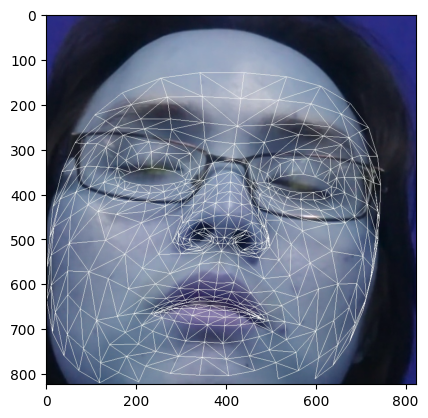

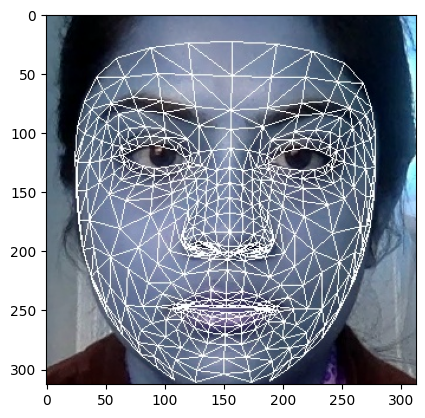

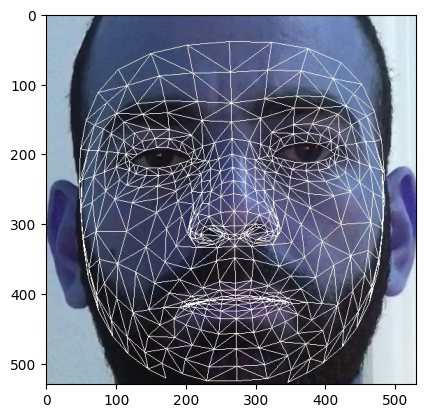

In [30]:
img_file = cv2.imread("/content/drowsiness_dataset/0 FaceImages/Fatigue Subjects/1022.jpg")
img_file1 = cv2.imread("/content/drowsiness_dataset/0 FaceImages/Active Subjects/3650.jpg")
plt.imshow(img_file)
plt.show()
plt.close()
plt.imshow(img_file1)
plt.show()
plt.close()
img_file2 = cv2.imread("/content/drowsiness_dataset/0 FaceImages/Active Subjects/4058.jpg")
plt.imshow(img_file2)
plt.show()
plt.close()

In [31]:
import os
import cv2

def face_for_yawn(direc='/content/drowsiness_dataset/0 FaceImages'):
    data = []  # Utilisation de 'data' au lieu de 'yaw_no'
    i = 1
    IMG_SIZE = 145
    categories = ["Fatigue Subjects", "Active Subjects"]

    for category in categories:
        path_link = os.path.join(direc, category)
        class_num = categories.index(category)
        print(class_num)

        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            resized_array = cv2.resize(image_array, (IMG_SIZE, IMG_SIZE))
            data.append([resized_array, class_num])

    return data

datas = face_for_yawn()

0
1


In [32]:
X = []
y = []
for feature, label in datas:
    X.append(feature)
    y.append(label)

In [33]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)

In [51]:
from sklearn.preprocessing import LabelEncoder
label_bin = LabelEncoder()
y = label_bin.fit_transform(y)
y = np.array(y)

In [35]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.20
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [36]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [37]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)  # shuffle = True de préférence pour melanger les batchs durant l'entraînement
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

In [38]:
# Model Elsafty 1
from keras.layers import BatchNormalization
model = tf.keras.models.Sequential()
# This is the first convolution
model.add(Conv2D(16, 3, activation='relu', input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(MaxPooling2D())
tf.keras.layers.Dropout(0.1)
# The second convolution
model.add(Conv2D(32, 5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
tf.keras.layers.Dropout(0.1)
# The third convolution
model.add(Conv2D(64, 10, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
tf.keras.layers.Dropout(0.1)
# The fourth convolution
model.add(Conv2D(128, 12, activation='relu'))
model.add(BatchNormalization())

# Flatten the results to feed into a DNN
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
# Only 1 output neuron.
model.add(Dense(1, activation='sigmoid'))
model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 143, 143, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 143, 143, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 71, 71, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 67, 67, 32)     │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 67, 67, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 33, 33, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │       204,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 1, 128)      │     1,179,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,423,713 (5.43 MB)

 Trainable params: 1,423,233 (5.43 MB)

 Non-trainable params: 480 (1.88 KB)

In [39]:
history = model.fit(train_generator, epochs=50, validation_data=test_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 85s 177ms/step - accuracy: 0.7130 - loss: 0.5592 - val_accuracy: 0.6305 - val_loss: 0.6784
Epoch 2/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 66s 160ms/step - accuracy: 0.7660 - loss: 0.4528 - val_accuracy: 0.7637 - val_loss: 0.4693
Epoch 3/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 79s 191ms/step - accuracy: 0.7871 - loss: 0.4177 - val_accuracy: 0.7597 - val_loss: 0.4954
Epoch 4/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 67s 161ms/step - accuracy: 0.8068 - loss: 0.3977 - val_accuracy: 0.8092 - val_loss: 0.3934
Epoch 5/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 62s 151ms/step - accuracy: 0.8193 - loss: 0.3718 - val_accuracy: 0.7323 - val_loss: 0.5127
Epoch 6/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 63s 153ms/step - accuracy: 0.8352 - loss: 0.3510 - val_accuracy: 0.8183 - val_loss: 0.3706
Epoch 7/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 62s 150ms/step - accuracy: 0.8548 - loss: 0.3132 - val_accuracy: 0.8246 - val_loss: 0.3539
Epoch 8/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 63s 151ms/step - accuracy: 0.8618 - loss: 0

In [41]:
model.save('Drowsiness_model.h5')

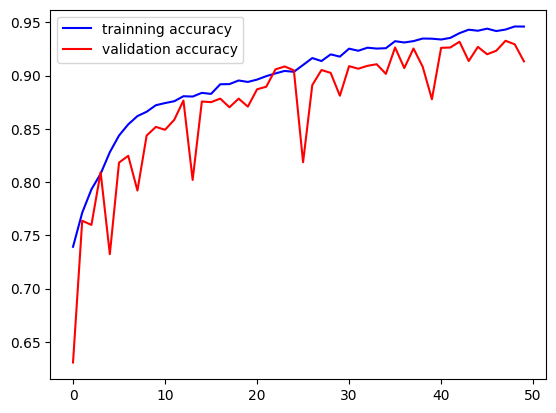

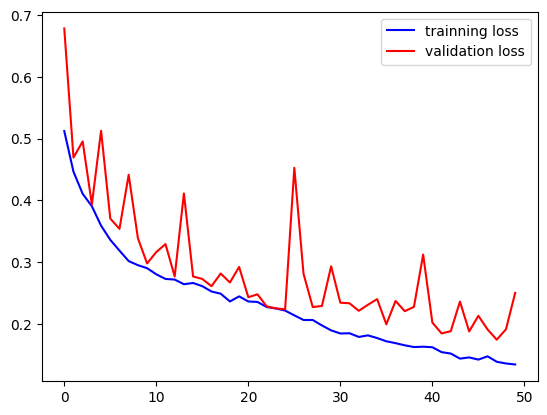

In [40]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, "b", label="trainning accuracy")
plt.plot(epochs, val_accuracy, "r", label="validation accuracy")
plt.legend()
plt.show()

plt.plot(epochs, loss, "b", label="trainning loss")
plt.plot(epochs, val_loss, "r", label="validation loss")
plt.legend()
plt.show()

In [49]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Étape 1 : prédire
y_pred = model.predict(test_generator)
# Comme tu utilises une sigmoïde (donc sortie entre 0 et 1), on doit threshold :
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()

# Étape 2 : récupérer les vrais labels
y_true = y_test

# Étape 3 : afficher les métriques
print("Accuracy :", accuracy_score(y_true, y_pred_classes))
print("Recall :", recall_score(y_true, y_pred_classes))
print("Precision :", precision_score(y_true, y_pred_classes))
print("F1 score :", f1_score(y_true, y_pred_classes))
print("\nClassification Report [Actives = '0', Fatigues = '1']:\n", classification_report(y_true, y_pred_classes))

104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
Accuracy : 0.9133715665559915
Recall : 0.9745562130177515
Precision : 0.8709677419354839
F1 score : 0.9198547891650377

**Classification Report** :
               precision    recall  f1-score   support

           0       0.97      0.85      0.91      1623
           1       0.87      0.97      0.92      1690

    accuracy                           0.91      3313
   macro avg       0.92      0.91      0.91      3313
weighted avg       0.92      0.91      0.91      3313



Le modèle parvient à détecter **97.45 %** des sujets somnolants(Fatigues).Ce qui est excellent car c'est plutôt l'objectif.

In [58]:
print(confusion_matrix(y_true, y_pred_classes))


[[1379  244]
 [  43 1647]]


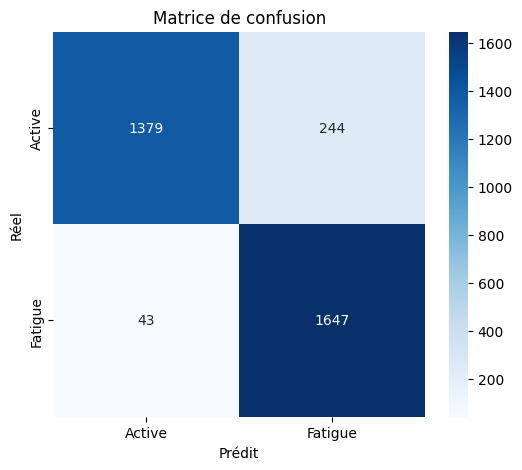

In [54]:
import seaborn as sns

conf_mat = confusion_matrix(y_test, (y_pred > 0.5).astype(int))

plt.figure(figsize=(6,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Active', 'Fatigue'], yticklabels=['Active', 'Fatigue'])
plt.xlabel('Prédit')
plt.ylabel('Réel')
plt.title('Matrice de confusion')
plt.show()

In [63]:
! pip install pydot graphviz


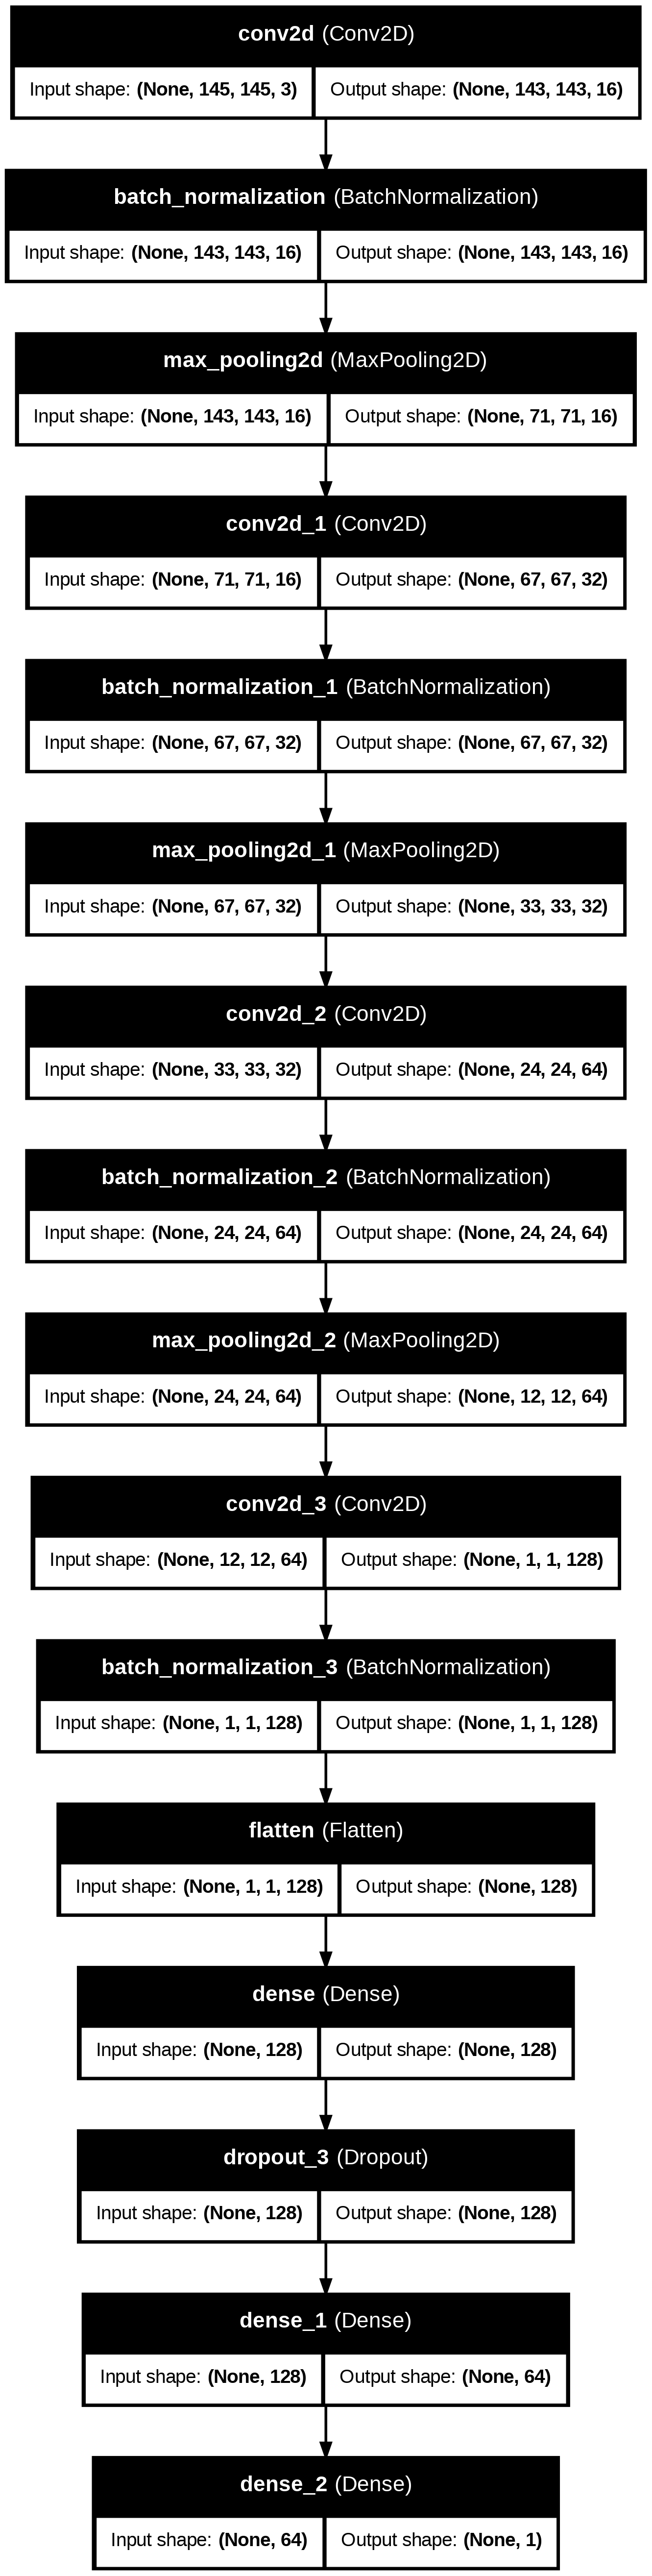

In [64]:
from tensorflow.keras.utils import plot_model
import pydot
from IPython.display import Image

# Génère le modèle sous forme de fichier PNG
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Utilise Graphviz pour l'affichage interactif (plus maniable)
from IPython.display import display
display(Image("model.png"))


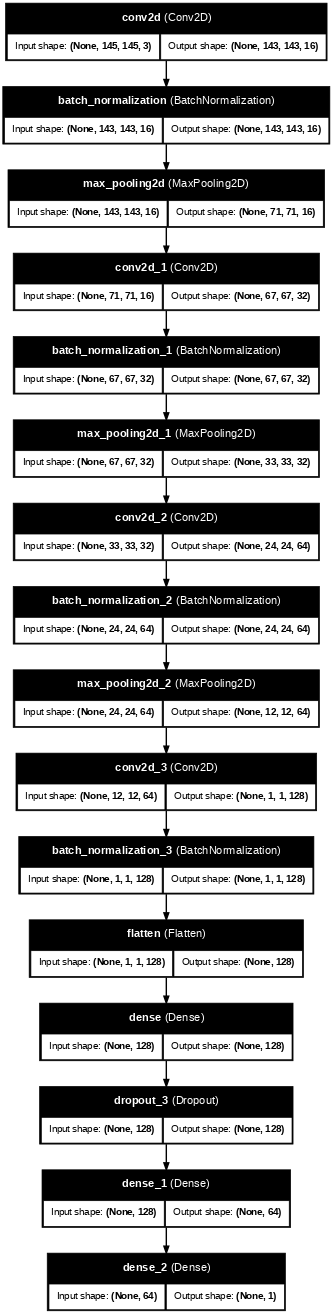

In [67]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, dpi=50)  # Réduit la résolution pour rendre l'image plus petite

from IPython.display import Image, display
display(Image(filename='model.png'))
